In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
seed= 1729        #1729          
pyro_seed= 68     #68      

import numpy as np
import torch
import pyro

np.random.seed(seed)
torch.manual_seed(seed)
pyro.set_rng_seed(pyro_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import os
import re
import glob
import time

import torch.nn as nn
from torch.utils import data

import pandas as pd
import scipy.misc as m
from math import isnan, isinf

import shutil
import argparse
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing as mp

from torch.distributions import Independent
from pyro.infer.reparam.transform import TransformReparam
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.nn import PyroModule, pyro_method
from pyro.distributions import Normal,TransformedDistribution
from pyro.distributions.transforms import Spline,affine_coupling,conditional_affine_coupling, affine_autoregressive,conditional_affine_autoregressive, AffineTransform, ExpTransform, ComposeTransform, spline_coupling 
from pyro.distributions.transforms import conditional_spline
from pyro.distributions.conditional import ConditionalTransformedDistribution

from utils import mkdir

### *Structural Causal Model*
$X_{4}=2\epsilon_{4}+1$
<br>
$X_{6}=\epsilon_{6}-1$
<br>
$X_{5}=3X_{6}+\epsilon_{5}-1$
<br>
$X_{2}=X_{5}-\epsilon_{2}$
<br>
$X_{3}=-3X_{4}+\epsilon_{3}-3$
<br>
$X_{1}=X_{6}-X_{5}+3\epsilon_{1}$
<br>
$Y=X_{1}+2X_{2}-3X_{3}+\epsilon_{Y}$


In [4]:
sample_size=20000 #20000
epsilon=np.random.normal(0,1,(sample_size,7))

In [5]:
def SCM(epsilon,intervention=False, *args):
    X_4=2*epsilon[:,4]+1
    X_6=epsilon[:,6]-1
    if not intervention:
        X_5=3*X_6+epsilon[:,5]-1
    else:
        X_5=np.full(sample_size,args)
    X_2=X_5-epsilon[:,2]
    X_3=-3*X_4+epsilon[:,3]-3
    X_1=X_6-X_5+3*epsilon[:,1]
    Y=X_1+2*X_2-3*X_3+epsilon[:,0]
    return X_6,X_5,X_4,X_3,X_2,X_1,Y

In [6]:
X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(epsilon,False)

In [7]:
Data={'X6':torch.tensor(X_6).reshape(-1,1).float(),'X5':torch.tensor(X_5).reshape(-1,1).float(),'X4':torch.tensor(X_4).reshape(-1,1).float(),'X3':torch.tensor(X_3).reshape(-1,1).float(),'X2':torch.tensor(X_2).reshape(-1,1).float(),'X1':torch.tensor(X_1).reshape(-1,1).float(),'Y':torch.tensor(Y).reshape(-1,1).float()}

### *Preprocessing the data*
---

In [8]:
class featuresDataset(data.Dataset):

    def __init__(self,dim = 1,noise=epsilon,
        inference = False, train = True,
        train_ratio = 0.8
        #random_seed = 67,
    ):
        super(featuresDataset, self).__init__()
        self.dim = dim
        #self.random_seed =   69 #random_seed
        self.inference = inference
        self.noise=noise

        self.data, self.y = [], []
        print('==> started preprocessing data ...')
        #X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(epsilon,False)
        #print(Y[0:5])
        for index in range(sample_size):
            self.data.append(dict(
                X6 =  np.asarray(X_6[index]).astype(np.float32),
                X5 =  np.asarray(X_5[index]).astype(np.float32),
                X4 =  np.asarray(X_4[index]).astype(np.float32),
                X3 =  np.asarray(X_3[index]).astype(np.float32),
                X2 =  np.asarray(X_2[index]).astype(np.float32),
                X1 =  np.asarray(X_1[index]).astype(np.float32),
                Y  =  np.asarray(Y[index]).astype(np.float32), 
                sample_id= index
            ))
        print('==> finished preprocessing data ...')

        if not self.inference:                                                      #when inference is flase 
            self.ids = np.arange(0, len(self.data))           
            np.random.seed(seed)
            np.random.shuffle(self.ids)
            last_train_sample = int(len(self.ids) * train_ratio)
            if train:                                                               #when training is true
                self.ids = self.ids[:last_train_sample]
            else:
                self.ids = self.ids[last_train_sample:]
        else:                                                                       #when inference is true
            self.ids = np.arange(0, len(self.data))


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id_ = self.ids[index]
        info = self.data[id_]
        
        id= info['sample_id']
        X6 = torch.from_numpy(info['X6'])
        X5 = torch.from_numpy(info['X5'])
        X4 = torch.from_numpy(info['X4'])
        X3 = torch.from_numpy(info['X3'])
        X2 = torch.from_numpy(info['X2'])
        X1 = torch.from_numpy(info['X1'])
        Y = torch.from_numpy(info['Y'])
        

        if self.inference:
            return X6, X5, X4,  X3, X2,  X1, Y, id
        else:
            return X6, X5, X4,  X3, X2,  X1, Y


def get_features_dataset(
    dim=1,
    inference=False,
    train_ratio=0.8,
    noise=epsilon
    #random_seed=67,
    ):

    if not inference:
        dataset_train = featuresDataset(train=True, dim=dim,noise=epsilon,
            train_ratio=train_ratio) #random_seed=random_seed)
        dataset_test = featuresDataset(train=False,  dim=dim,noise=epsilon,
            train_ratio=train_ratio) #random_seed=random_seed)

        return dataset_train, dataset_test
    else:
        dataset = featuresDataset(inference=True,  dim=dim,noise=epsilon,
            train_ratio=train_ratio) #random_seed=random_seed)

        return dataset

### Flow based SCMs
---
## Full Model

In [9]:
#full model

class ConditionalSCM(PyroModule):
    def __init__(self,context_dim=2,normalize=True,spline_bins=8,spline_order='linear'):
        super(ConditionalSCM, self).__init__()
        self.context_dim = context_dim
        self.spline_bins = spline_bins
        self.spline_order = spline_order
        self.normalize = normalize
        

        
        #Flows ---------------------------------------------------------------------------------------------
        
        # X_4 flows
        self.X4_flow_component =  affine_coupling(1)                         #Spline(1, count_bins=self.spline_bins)
        self.X4_flow_transforms = ComposeTransform([self.X4_flow_component])
        
        # X_6 flows
        self.X6_flow_component =   affine_coupling(1)                        #Spline(1, count_bins=self.spline_bins)
        self.X6_flow_transforms = ComposeTransform([self.X6_flow_component])
        
        #X_5 flows
        self.X5_flow_component =   conditional_affine_coupling(input_dim=1, context_dim=1,hidden_dims=[10,10])  #conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X5_flow_transforms = ComposeTransformModule([self.X5_flow_component])
        
        #X_2 flows 
        self.X2_flow_component =     conditional_affine_coupling(input_dim=1, context_dim=1,hidden_dims=[10,10]) #conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X2_flow_transforms = ComposeTransformModule([self.X2_flow_component])
        
        #X_3 flows 
        self.X3_flow_component =     conditional_affine_coupling(input_dim=1, context_dim=1,hidden_dims=[10,10])                         #conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X3_flow_transforms = ComposeTransformModule([self.X3_flow_component])
        
        
        #X_1 flows 
        self.X1_flow_component =     conditional_affine_coupling(input_dim=1, context_dim=2,hidden_dims=[10,10])          #conditional_spline(1, context_dim=2, count_bins=self.spline_bins, order=self.spline_order)
        self.X1_flow_transforms = ComposeTransformModule([self.X1_flow_component])
        
        #Y flows
        self.Y_flow_component =  conditional_affine_coupling(input_dim=1, context_dim=3,hidden_dims=[10,10])                                        #conditional_spline(1, context_dim=3, count_bins=self.spline_bins, order=self.spline_order)
        self.Y_flow_transforms = ComposeTransformModule([self.Y_flow_component])
        
       

            
    def pgm_model(self,**kwargs):
        loc=torch.tensor([0.0])
        scale=torch.tensor([1.0])
        
        #observed={}
        #if kwargs:
        #    for key, value in kwargs.items():
        #        observed[key]=value
        #else:
        #    observed={'X4':None,'X6':None,'X5':None,'X3':None,'X2':None,'X1':None,'Y':None}
        
        
        
        
        
        # X4
        self.X4_base_dist = Normal(loc,scale).to_event(1)
        self.X4_dist=TransformedDistribution(self.X4_base_dist, self.X4_flow_transforms)
        self.X4 = pyro.sample('X4', self.X4_dist,) #obs=observed['X4']
        # X6
        self.X6_base_dist = Normal(loc,scale).to_event(1)
        self.X6_dist=TransformedDistribution(self.X6_base_dist, self.X6_flow_transforms)
        self.X6 = pyro.sample('X6', self.X6_dist,) #obs=observed['X6']
        #X5
        context_X5=torch.cat([self.X6],-1)
        self.X5_base_dist = Normal(loc,scale).to_event(1)
        self.X5_dist = ConditionalTransformedDistribution(self.X5_base_dist, self.X5_flow_transforms)
        self.X5 = pyro.sample('X5', self.X5_dist.condition(context_X5),) #obs=observed['X5']
        #X3
        context_X3=torch.cat([self.X4],-1)
        self.X3_base_dist = Normal(loc,scale).to_event(1)
        self.X3_dist = ConditionalTransformedDistribution(self.X3_base_dist, self.X3_flow_transforms)
        self.X3 = pyro.sample('X3', self.X3_dist.condition(context_X3),) #obs=observed['X3']
        #X2
        context_X2=torch.cat([self.X5],-1)
        self.X2_base_dist = Normal(loc,scale).to_event(1)
        self.X2_dist = ConditionalTransformedDistribution(self.X2_base_dist, self.X2_flow_transforms)
        self.X2 = pyro.sample('X2', self.X2_dist.condition(context_X2),) #obs=observed['X2']
        #X1
        context_X1=torch.cat([self.X5,self.X6],-1)
        #print('context_X1',context_X1)
        self.X1_base_dist = Normal(loc,scale).to_event(1)
        self.X1_dist = ConditionalTransformedDistribution(self.X1_base_dist, self.X1_flow_transforms)
        self.X1 = pyro.sample('X1', self.X1_dist.condition(context_X1),) #obs=observed['X1']
        # Y
        context_Y=torch.cat([self.X3,self.X2,self.X1],-1)
        self.Y_base_dist = Normal(loc,scale).to_event(1)
        self.Y_dist = ConditionalTransformedDistribution(self.Y_base_dist, self.Y_flow_transforms)
        self.Y = pyro.sample('Y', self.Y_dist.condition(context_Y),) #obs=observed['Y']
       
        
        

    def forward(self, X6,X5, X4,X3,X2,X1,Y ):
        self.pgm_model() #**{"X6":X6,"X5": X5,"X4": X4,"X3":X3,"X2":X2,"X1":X1,"Y":Y})
        
        
                
 
        
        
        context_X5=torch.cat([X6],-1).detach()
        context_X3=torch.cat([X4],-1).detach()
        context_X2=torch.cat([X5],-1).detach()
        context_X1=torch.cat([X5,X6],-1).detach()
        context_Y=torch.cat([X3,X2,X1],-1).detach()
         
        X6_logp = self.X6_dist.log_prob(X6)
        X5_logp = self.X5_dist.condition(context_X5).log_prob(X5)
        X4_logp = self.X4_dist.log_prob(X4)
        X3_logp = self.X3_dist.condition(context_X3).log_prob(X3)
        X2_logp = self.X2_dist.condition(context_X2).log_prob(X2)
        X1_logp = self.X1_dist.condition(context_X1).log_prob(X1)
        Y_logp = self.Y_dist.condition(context_Y).log_prob(Y)
        
        return {'X_6':X6_logp,'X_5':X5_logp,'X_4': X4_logp, 'X_3': X3_logp, 'X_2': X2_logp, 'X_1': X1_logp,'Y': Y_logp}

    def clear(self):
        self.X5_dist.clear_cache()
        self.X3_dist.clear_cache()
        self.X2_dist.clear_cache()
        self.X1_dist.clear_cache()
        self.Y_dist.clear_cache()
        
    def model(self):
        self.pgm_model()
        return self.X6, self.X5, self.X4, self.X3, self.X2, self.X1, self.Y

    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None
        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)

    def sample(self, n_samples=1):
        with pyro.plate('sample_observations', n_samples):
            samples = self.model()
        return (*samples,)

    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()
        return (*samples,)
    
    def infer_exogeneous(self, **obs):
        cond_sample = pyro.condition(self.sample, data=obs)
        cond_trace = pyro.poutine.trace(cond_sample).get_trace(obs['X1'].shape[0])
        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue
            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist

            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output

    def counterfactual(self, obs,intervention, num_particles=1):
        counterfactuals = []

        for _ in range(num_particles):
            exogeneous = self.infer_exogeneous(**obs)
            condition= {intervention.split('=')[0].split('(')[-1] :torch.full_like( obs['X4'],float(intervention.split('=')[-1][:-1]))}
            counter = pyro.poutine.do(pyro.poutine.condition(self.sample_scm, data=exogeneous), data=condition)(obs['X1'].shape[0]) 
            counterfactuals += [counter]
            #print('helper',helper)
            #print('helper',helper)

        return {k: v for k, v in zip(('X_6','X_5','X_4', 'X_3', 'X_2', 'X_1','Y'), (torch.stack(c).mean(0) for c in zip(*counterfactuals)))}


def conditionalscm():
    model = ConditionalSCM(context_dim=2,normalize=True,spline_bins=16,spline_order='linear')
    return model


In [10]:
scm=conditionalscm()

/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [11]:
#scm.sample()

In [12]:
#data_ = {'X6': torch.rand(1).reshape(-1,1),
#        'X5': torch.rand(1).reshape(-1,1),
#        'X4': torch.rand(1).reshape(-1,1), 
#        'X3': torch.rand(1).reshape(-1,1), 
#        'X2': torch.rand(1).reshape(-1,1),
#        'X1': torch.rand(1).reshape(-1,1),
#        'Y': torch.rand(1).reshape(-1,1)} 
#print(data_)
#data2 = {'X6': torch.rand(2).reshape(-1,1),
#        'X5': torch.rand(2).reshape(-1,1),
#        'X4': torch.rand(2).reshape(-1,1), 
#        'X3': torch.rand(2).reshape(-1,1), 
#        'X2': torch.rand(2).reshape(-1,1),
#        'X1': torch.rand(2).reshape(-1,1),
#        'Y': torch.rand(2).reshape(-1,1)} 
#print(data2)

Note that, in the full model, we infer state of all $\epsilon_{i}$'s

In [13]:
#print(scm.infer_exogeneous(**data_))
#exogeneous=scm.infer_exogeneous(**data_)
#print(scm.infer_exogeneous(**data2))
#exogeneous=scm.infer_exogeneous(**data2)


In [14]:
#intervention='do(X5=0.7)'
#print(scm.counterfactual(obs=data2,intervention=intervention))

### Partial model

In [15]:
#partial model

class ConditionalSCM_partial(PyroModule):
    def __init__(self,context_dim=2,normalize=True,spline_bins=8,spline_order='linear'):
        super(ConditionalSCM_partial, self).__init__()
        self.context_dim = context_dim
        self.spline_bins = spline_bins
        self.spline_order = spline_order
        self.normalize = normalize
        

        
        #Flows ---------------------------------------------------------------------------------------------
        
        # X_4 flows
        #self.X4_flow_component = Spline(1, count_bins=self.spline_bins)
        #self.X4_flow_transforms = ComposeTransform([self.X4_flow_component])
        
        # X_3 flows
        #self.X3_flow_component = Spline(1, count_bins=self.spline_bins)
        #self.X3_flow_transforms = ComposeTransform([self.X3_flow_component])
        
        #X_2 flows 
        self.X2_flow_component =  conditional_affine_coupling(input_dim=1, context_dim=1,hidden_dims=[10,10])  #conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X2_flow_transforms = ComposeTransformModule([self.X2_flow_component])
        
        #X_1 flows 
        self.X1_flow_component = conditional_affine_coupling(input_dim=1, context_dim=2,hidden_dims=[10,10])  #conditional_spline(1, context_dim=2, count_bins=self.spline_bins, order=self.spline_order)
        self.X1_flow_transforms = ComposeTransformModule([self.X1_flow_component])
        
        #Y flows
        self.Y_flow_component = conditional_affine_coupling(input_dim=1, context_dim=3,hidden_dims=[10,10])  #conditional_spline(1, context_dim=3, count_bins=self.spline_bins, order=self.spline_order)
        self.Y_flow_transforms = ComposeTransformModule([self.Y_flow_component])
        
       

            
    def pgm_model(self,**kwargs):
        loc=torch.tensor([0.0])
        scale=torch.tensor([1.0])
        
        #observed={}
        #if kwargs:
        #    for key, value in kwargs.items():
        #        observed[key]=value
        #else:
        #    observed={'X4':None,'X6':None,'X5':None,'X3':None,'X2':None,'X1':None,'Y':None}
        
        
         # X4
        self.X4_dist = Normal(loc,scale).to_event(1)
        #self.X4_dist=TransformedDistribution(self.X4_base_dist, self.X4_flow_transforms)
        self.X4 = pyro.sample('X4', self.X4_dist,) #obs=observed['X4'])
        # X6
        self.X6_dist = Normal(loc,scale).to_event(1)
        #self.X6_dist=TransformedDistribution(self.X6_base_dist, self.X6_flow_transforms)
        self.X6 = pyro.sample('X6', self.X6_dist,)#obs=observed['X6'])
        #X5
        #context_X5=torch.cat([self.X6],-1)
        self.X5_dist = Normal(loc,scale).to_event(1)
        #self.X5_dist = ConditionalTransformedDistribution(self.X5_base_dist, self.X5_flow_transforms).condition(context_X5)
        self.X5 = pyro.sample('X5', self.X5_dist,)#obs=observed['X5'])
        #X3
        #context_X3=torch.cat([self.X4],-1)
        self.X3_dist = Normal(loc,scale).to_event(1)
        #self.X3_dist = ConditionalTransformedDistribution(self.X3_base_dist, self.X3_flow_transforms).condition(context_X3)
        self.X3 = pyro.sample('X3', self.X3_dist,)#obs=observed['X3'])
        
        #X2
        context_X2=torch.cat([self.X5],-1)
        self.X2_base_dist = Normal(loc,scale).to_event(1)
        self.X2_dist = ConditionalTransformedDistribution(self.X2_base_dist, self.X2_flow_transforms)
        self.X2 = pyro.sample('X2', self.X2_dist.condition(context_X2),)#obs=observed['X2'])
        #X1
        context_X1=torch.cat([self.X5,self.X6],-1)
        self.X1_base_dist = Normal(loc,scale).to_event(1)
        self.X1_dist = ConditionalTransformedDistribution(self.X1_base_dist, self.X1_flow_transforms)
        self.X1 = pyro.sample('X1', self.X1_dist.condition(context_X1),)#obs=observed['X1'])
        # Y
        context_Y=torch.cat([self.X3,self.X2,self.X1],-1)
        self.Y_base_dist = Normal(loc,scale).to_event(1)
        self.Y_dist = ConditionalTransformedDistribution(self.Y_base_dist, self.Y_flow_transforms)
        self.Y = pyro.sample('Y', self.Y_dist.condition(context_Y),)#obs=observed['Y'])
       
        
        

    def forward(self, X6, X5, X4,X3,X2,X1,Y ):
        self.pgm_model() #**{"X6":X6,"X5": X5,"X4": X4,"X3":X3,"X2":X2,"X1":X1,"Y":Y})
        
        
        
        context_X2=torch.cat([X5],-1).detach()
        context_X1=torch.cat([X5,X6],-1).detach()
        context_Y=torch.cat([X3,X2,X1],-1).detach()        
        
        Y_logp = self.Y_dist.condition(context_Y).log_prob(Y)
        X1_logp = self.X1_dist.condition(context_X1).log_prob(X1)
        X2_logp = self.X2_dist.condition(context_X2).log_prob(X2)
        
        X3_logp = torch.zeros(Y_logp.shape) #.detach()                                  #self.X3_dist.log_prob(X3)                  
        X4_logp = torch.zeros(Y_logp.shape) #.detach()                                  #self.X4_dist.log_prob(X4)                                
        X5_logp = torch.zeros(Y_logp.shape) #.detach()                                  #self.X2_dist.log_prob(X2)
        X6_logp = torch.zeros(Y_logp.shape) #.detach()                                  #self.X1_dist.log_prob(X1)
        
        return {'X_6': X6_logp,'X_5': X5_logp,'X_4': X4_logp, 'X_3': X3_logp, 'X_2': X2_logp, 'X_1': X1_logp,'Y': Y_logp}

    def clear(self):
        self.X2_dist.clear_cache()
        self.X1_dist.clear_cache()
        self.Y_dist.clear_cache()
        
        
        
    def partial_model(self,**obs):
        self.pgm_model()
        
        X4=  obs['X4']       
        X6 = obs['X6']                
        X5 = obs['X5']                   
        X3 = obs['X3']
        context_X2=torch.cat([X5],-1)
        X2 = pyro.sample('X2', self.X2_dist.condition(context_X2),)
        context_X1=torch.cat([X5,X6],-1)
        X1 = pyro.sample('X1', self.X1_dist.condition(context_X1),)
        context_Y=torch.cat([X3,X2,X1],-1)
        Y = pyro.sample('Y', self.Y_dist.condition(context_Y),) 

        return  X6, X5, X4, X3, X2, X1, Y
        
    def partial_sample(self,**observed):
        with pyro.plate('partial_observation', observed['X4'].shape[0]):
          samples = self.partial_model(**observed)
        return (*samples,)
    
        
        
        
        
        
    def model(self):
        self.pgm_model()
        return self.X6, self.X5, self.X4, self.X3, self.X2, self.X1, self.Y

    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None
        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)

    def sample(self, n_samples=1):
        with pyro.plate('sample_observations', n_samples):
            samples = self.model()
        return (*samples,)

    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()
        return (*samples,)
    
    def infer_exogeneous(self, **obs):
        cond_sample = pyro.condition(self.sample, data=obs)
        cond_trace = pyro.poutine.trace(cond_sample).get_trace(obs['X1'].shape[0])
        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue
            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist

            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output

    def counterfactual(self, obs, intervention, num_particles=1):
        counterfactuals = []
        for _ in range(num_particles):
            exogeneous = self.infer_exogeneous(**obs)
            condition= {intervention.split('=')[0].split('(')[-1] :torch.full_like( obs['X4'],float(intervention.split('=')[-1][:-1]))}
            condition['X3']=obs['X3']
            condition['X4']=obs['X4']
            condition['X6']=obs['X6']
            #print('condition',condition)
            counter = pyro.poutine.do(pyro.poutine.condition(self.sample_scm, data=exogeneous), data=condition)(obs['X1'].shape[0])
            counterfactuals += [counter]
        return {k: v for k, v in zip(('X_6','X_5','X_4', 'X_3', 'X_2', 'X_1','Y'), (torch.stack(c).mean(0) for c in zip(*counterfactuals)))}


def conditionalscm_partial():
    model = ConditionalSCM_partial(context_dim=2,normalize=True,spline_bins=16,spline_order='linear')
    return model


In [16]:
scm_partial=conditionalscm_partial()
#print(scm_partial.sample(n_samples=2))

Note that we only infer $\epsilon_{2},\epsilon_{1}$ and $\epsilon_{Y}$. We hard intervene on $X_{5}$

In [17]:
#print(scm_partial.infer_exogeneous(**data2))

In [18]:
#intervention='do(X5=3)'
#print(scm_partial.counterfactual(obs=data_,intervention=intervention))

### Training function 
---

**training hyperparameter**

In [19]:
#data_seed=69    #default 69
batch_size=128
test_batch_size=64
lr=1e-3  #0.1            #3e-4
weight_decay=0     #1e-3
epochs=1000
lr_annealing=True
log_interval=100
#seed=17        #default 17
save='./logs'    #filepath to save training logs

In [20]:
def milestone_step( optimizer, epoch):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

In [21]:
import os
import time
#import torch
import shutil
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing as mp
from utils import mkdir
from collections import Counter



def save_checkpoint(state, is_best, filepath):
    mkdir(filepath)
    torch.save(state, os.path.join(filepath, 'flow_ckpt.pth.tar'))
    if is_best:
        shutil.copyfile(os.path.join(filepath, 'flow_ckpt.pth.tar'), os.path.join(filepath, 'flow_best.pth.tar'))
        #print('best is saved')
#---------------------------------------------------------------------------------------------------------------


def train( model, optimizer, train_loader, epoch):
    avg_loss = 0.
    for batch_idx, (X6,X5,X4,X3, X2, X1,Y) in enumerate(train_loader):
        X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
        optimizer.zero_grad()
        log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
        loss = -torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        model.clear()
        #if epoch % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.1f}%)]\t| -LogProb X6: {:.6f}\tX5: {:.6f}\tX4: {:.6f}\tX3: {:.6f} \tX2: {:.6f}\tX1: {:.6f} \tY: {:.6f} \tTotal logprob: {:.6f}'.format(epoch, batch_idx * len(X1),
                #len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                #-torch.mean(log_p['X_6']).item(), -torch.mean(log_p['X_5']).item(),
                #-torch.mean(log_p['X_4']).item(), -torch.mean(log_p['X_3']).item(),
                #-torch.mean(log_p['X_2']).item(), -torch.mean(log_p['X_1']).item(),-torch.mean(log_p['Y']).item(), -loss.item()))
    avg_loss /= -len(train_loader)
    if epoch % log_interval ==0:
        print('Epoch:',epoch,'\nTrain set: Average LogProb: {:.6f}\n'.format(avg_loss))
    
            
            

def test(model, test_loader):
    test_loss = 0.
    model.eval()
    associative_power ={'X_6':0,'X_5':0,'X_4':0,'X_3':0,'X_2':0,'X_1':0,'Y':0}
    for X6, X5, X4, X3, X2, X1,Y in test_loader:
        with torch.no_grad():
            X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
            log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
            test_loss += torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
            for k,v in log_p.items():
                associative_power[k]+=torch.mean(v)
                #print(k,v)
                
                
    #print('length',len(test_loader))            
    test_loss /= len(test_loader)   #len(test_loader.dataset)
    associative_power=dict(associative_power) 
    associative_power={k: v/len(test_loader) for k,v in associative_power.items()}
    #print('associative power',associative_power, 'sum',sum(associative_power.values()))
    #print('\nTest set: Average LogProb: {:.6f}\n'.format(test_loss))
    #print('--------------------------------------------------')
    return test_loss, associative_power
#--------------------------------------------------------------------------------------------------------------
def main(model_name,filepath):
    kwargs =  {}
    seed=21
    dataset_train, dataset_test = get_features_dataset( dim=1,noise=epsilon) #random_seed=data_seed)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size, shuffle=False, **kwargs)

    model = model_name
 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 0)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') 

    best_loss = -500.
    start_time = time.time()
    for epoch in range(epochs):
 
        #if epoch %7 ==2:
            
        train( model, optimizer, train_loader, epoch)
        loss,ass_power = test(model, test_loader)
        if epoch%100==0:
            print('\nTest set: Average LogProb: {:.6f}\n'.format(loss))
        if not lr_annealing:
            milestone_step(optimizer, epoch)
        #else:
            #scheduler.step() #loss)
        
        is_best = loss > best_loss
        best_loss = max(loss, best_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict(),
            'associative power':ass_power
        }, is_best, filepath=filepath)

    del model
    print('==> Best LogProb: {:.6f}, Time: {:.2f} min\n'.format(best_loss, (time.time()-start_time)/60.))
    

    
def train_model(model,path):
    mkdir(path)
    path = os.path.join(path, str(model.__class__.__name__))
    mkdir(path)
    filepath=path
    main(model,filepath)
    

### train scm 
---
We haven't trained the models yet. We need to train them to get proper counterfactuals.

In [22]:
batch_size=128
test_batch_size=64
lr=1e-3  #0.1            #3e-4
weight_decay=0    #1e-3
epochs=1000
lr_annealing=True
log_interval=100
save='./logs'

In [23]:
train_model(scm,save)

==> started preprocessing data ...
==> finished preprocessing data ...
==> started preprocessing data ...
==> finished preprocessing data ...
Epoch: 0 
Train set: Average LogProb: -171.930964


Test set: Average LogProb: -46.686749

Epoch: 100 
Train set: Average LogProb: -11.744967


Test set: Average LogProb: -11.755004

Epoch: 200 
Train set: Average LogProb: -11.732804


Test set: Average LogProb: -11.742023

Epoch: 300 
Train set: Average LogProb: -11.730620


Test set: Average LogProb: -11.749091

Epoch: 400 
Train set: Average LogProb: -11.732099


Test set: Average LogProb: -11.742863

Epoch: 500 
Train set: Average LogProb: -11.726644


Test set: Average LogProb: -11.746066

Epoch: 600 
Train set: Average LogProb: -11.726585


Test set: Average LogProb: -11.740232

Epoch: 700 
Train set: Average LogProb: -11.727175


Test set: Average LogProb: -11.750815

Epoch: 800 
Train set: Average LogProb: -11.725387


Test set: Average LogProb: -11.761575

Epoch: 900 
Train set: Average 

### train scm_partial
---

In [24]:
batch_size=128
test_batch_size=64
lr=1e-3  #0.1            #3e-4
weight_decay=0    #1e-3
epochs=1000
lr_annealing=True
log_interval=100
save='./logs' 

In [25]:
train_model(scm_partial,save)

==> started preprocessing data ...
==> finished preprocessing data ...
==> started preprocessing data ...
==> finished preprocessing data ...
Epoch: 0 
Train set: Average LogProb: -35.689421


Test set: Average LogProb: -12.973021

Epoch: 100 
Train set: Average LogProb: -5.378089


Test set: Average LogProb: -5.392345

Epoch: 200 
Train set: Average LogProb: -5.356988


Test set: Average LogProb: -5.390164

Epoch: 300 
Train set: Average LogProb: -5.354858


Test set: Average LogProb: -5.377345

Epoch: 400 
Train set: Average LogProb: -5.351629


Test set: Average LogProb: -5.365634

Epoch: 500 
Train set: Average LogProb: -5.349426


Test set: Average LogProb: -5.363352

Epoch: 700 
Train set: Average LogProb: -5.348078


Test set: Average LogProb: -5.364767

Epoch: 800 
Train set: Average LogProb: -5.351113


Test set: Average LogProb: -5.383005

Epoch: 900 
Train set: Average LogProb: -5.350438


Test set: Average LogProb: -5.367177

==> Best LogProb: -5.362494, Time: 10.48 min



## Goodness of Estimation

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

In [27]:
#scm_sample=scm.sample(n_samples=2000)
#scm_sample={'X6':scm_sample[0].detach(),'X5':scm_sample[1].detach(),'X4':scm_sample[2].detach(),'X3':scm_sample[3].detach(),'X2':scm_sample[4].detach(),'X1':scm_sample[5].detach(),'Y':scm_sample[6].detach()}


In [28]:
#scm_partial_sample=scm_partial.sample(n_samples=2000)
#scm_partial_sample={'X6':scm_partial_sample[0].detach(),'X5':scm_partial_sample[1].detach(),'X4':scm_partial_sample[2].detach(),'X3':scm_partial_sample[3].detach(),'X2':scm_partial_sample[4].detach(),'X1':scm_partial_sample[5].detach(),'Y':scm_partial_sample[6].detach()}

In [29]:
#sns.distplot(Data['Y'].numpy(),kde=True,color='red')
#sns.distplot(scm_sample['Y'].numpy(),kde=True,color='yellow')
#sns.distplot(scm_partial_sample['Y'].numpy(),kde=True,color='green')

In [30]:
#inferred_noise_scm=scm.infer_exogeneous(**Data)
#inferred_noise_scm_partial=scm_partial.infer_exogeneous(**Data)


In [31]:

#sns.distplot(inferred_noise_scm['Y_base'].detach(),color='yellow')
#sns.distplot(inferred_noise_scm_partial['Y_base'].detach(),color='green')
#sns.distplot(epsilon[:,0],color='red')

In [32]:
#j=10
#intervention='do(X5='+str(j)+')'
#scm_partial_counterfactuals=scm_partial.counterfactual(obs=Data,intervention=intervention)
#scm_counterfactuals=scm.counterfactual(obs=Data,intervention=intervention)
#X6_cf,X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon,True,j) 

In [33]:

#sns.distplot(scm_partial_counterfactuals['Y'].detach(),color='green')
#sns.distplot(scm_counterfactuals['Y'].detach(),color='yellow')
#sns.distplot( Y_cf,color='red')
#sns.distplot(epsilon[:,1],color='gray')
#sns.distplot(inferred_noise_scm['X1_base'].detach(),color='orange')
#sns.distplot(inferred_noise_scm_partial['X1_base'].detach(),color='black')

### **Inference**
---

In [34]:
def do_inference(model_name,intervention,noise=epsilon):
    #kwargs = {}
    #dataset = get_features_dataset(inference=True, dim=dim,noise=epsilon) #random_seed=9)
    #loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, **kwargs)


    
    model = model_name
    saved_in_path= os.path.join(save,str(model_name.__class__.__name__)) 
    model_path = os.path.join(saved_in_path, 'flow_best.pth.tar')
    checkpoint = torch.load(model_path)
    print('\n',model_path)
    print('====>>> Best LogProb: {:.6f}\n'.format(checkpoint['best_loss']))
    print('associative power:',checkpoint['associative power'])
    
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    print('intervention------',intervention)
    #model.clear()
    #feature = FeaturesInference(args, model, loader, dataset.data, dataset.covariates_dict)
    #feature.inference()
    #Counterfactuals={'X_6':[],'X_5':[],'X_4':[],'X_3':[],'X_2':[],'X_1':[],'Y':[]}
    #print('before starting---',Counterfactuals)
    #start_time=time.time()
    #for batch_idx, (X6, X5, X4, X3, X2, X1,Y,id) in enumerate(loader):
            #with torch.no_grad():
                #X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
                #data = {'X6': X6,'X5': X5,'X4': X4, 'X3': X3, 'X2': X2, 'X1': X1,'Y':Y}
                #print('intervention',intervention)
    if 'partial' in model.__class__.__name__:
        Samples=model.partial_sample(n_samples=1000,**Data)  
        samples={'X6':Samples[0].detach(),'X5':Samples[1].detach(),'X4':Samples[2].detach(),'X3':Samples[3].detach(),'X2':Samples[4].detach(),'X1':Samples[5].detach(),'Y':Samples[6].detach()}
    else:
        Samples=model.sample(n_samples=sample_size)  
        samples={'X6':Samples[0].detach(),'X5':Samples[1].detach(),'X4':Samples[2].detach(),'X3':Samples[3].detach(),'X2':Samples[4].detach(),'X1':Samples[5].detach(),'Y':Samples[6].detach()}

    Exogeneous_noise=model.infer_exogeneous(**Data)
    Counterfactuals = model.counterfactual(obs=Data, intervention=intervention) #, num_particles=particles)
                #if batch_idx % log_interval == 0:
                    #print('Inference: [{}/{} ({:.1f}%)]\tIntervention: {}'.format(
                        #batch_idx * len(X4), len(loader.dataset), 100. * batch_idx / len(loader), intervention))
                    #print(samples)
                #for key,value in Counterfactuals.items():
                    #Counterfactuals[key] .append(np.array(samples[key]))

    #print(' Time taken: {:.2f} secs'.format( (time.time()-start_time)))
    
    #for key,value in Counterfactuals.items():
        #Counterfactuals[key]= np.vstack(Counterfactuals[key]).reshape(sample_size) 
    
    return samples ,Exogeneous_noise, Counterfactuals



### *Generate counterfactuals*

In [35]:
save='logs'

In [36]:
j= 5
intervention='do(X5='+str(j)+')'
X6_cf,X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon,True,j)      #True Counterfactuals
print(np.mean(Y_cf))
#print(Y_cf[0:5])

21.986083302818606


In [37]:
SCM_samples,SCM_inferred_noise,SCM_counterfactuals=do_inference(scm,intervention,noise=epsilon)
#np.mean(SCM_counterfactuals['Y'])
#SCM_counterfactuals['Y'].detach().mean()


 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=5)


In [38]:
SCM_partial_samples,SCM_partial_inferred_noise,SCM_partial_counterfactuals=do_inference(scm_partial,intervention,noise=epsilon)
#print(SCM_partial_counterfactuals['Y'].detach().mean())
#SCM_partial_counterfactuals['Y'].detach().numpy().reshape(-1)


 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative power: {'X_6': tensor(0.), 'X_5': tensor(0.), 'X_4': tensor(0.), 'X_3': tensor(0.), 'X_2': tensor(-1.4160), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4415)}
intervention------ do(X5=5)


In [39]:
def error_estimate(inferred_noise):
    dict={}
    for key,value in inferred_noise.items():
        t=key.split('_')[0][-1]
        if t=='Y':
            s=0
        else:
            s=int(t)
        dict[key.split('_')[0]+' error']=np.linalg.norm(inferred_noise[key].detach().numpy().reshape(-1)-epsilon[:,s])/sample_size
    return dict

print('full model:', error_estimate(SCM_inferred_noise))
print('\npartial model:', error_estimate(SCM_partial_inferred_noise))
    

full model: {'X4 error': 1.320762470268288e-05, 'X6 error': 2.1691414074197818e-05, 'X5 error': 0.0003222385717188488, 'X3 error': 0.00037214870748754163, 'X2 error': 0.014082458709793499, 'X1 error': 0.0002505640417761604, 'Y error': 0.00047844779565659536}

partial model: {'X2 error': 0.014088917682052395, 'X1 error': 0.000315594889437939, 'Y error': 0.00044466696524917494}


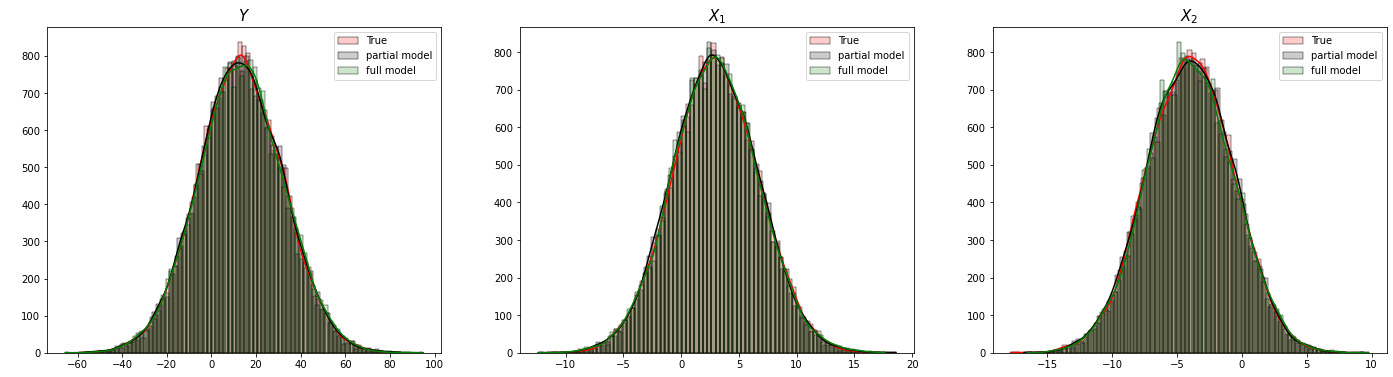

In [40]:
#sns.distplot(Data['Y'].numpy(),kde=True,color='red')
#sns.distplot(SCM_samples['Y'].numpy().reshape(-1),kde=True,color='yellow')
#sns.distplot(SCM_partial_samples['Y'].numpy().reshape(-1),kde=True,color='black')



sample_Y={'True':Data['Y'].reshape(-1),'full':SCM_samples['Y'].detach().numpy().reshape(-1),'partial':SCM_partial_samples['Y'].detach().numpy().reshape(-1)}
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 6))
sns.histplot(sample_Y['True'], ax=ax1, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(sample_Y['partial'], ax=ax1,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_Y['full'], ax=ax1,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax1.legend()
ax1.set_ylabel(' ',fontweight='bold')
ax1.set_title(r'$Y$',fontsize=15)

sample_X1={'True':Data['X1'].reshape(-1),'full':SCM_samples['X1'].detach().numpy().reshape(-1),'partial':SCM_partial_samples['X1'].detach().numpy().reshape(-1)}
sns.histplot(sample_X1['True'], ax=ax2, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(sample_X1['partial'], ax=ax2,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X1['full'], ax=ax2,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax2.legend()
ax2.set_ylabel(' ',fontweight='bold')
ax2.set_title(r'$X_{1}$',fontsize=15)


sample_X2={'True':Data['X2'].reshape(-1),'full':SCM_samples['X2'].detach().numpy().reshape(-1),'partial':SCM_partial_samples['X2'].detach().numpy().reshape(-1)}
sns.histplot(sample_X2['True'], ax=ax3, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(sample_X2['partial'], ax=ax3,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X2['full'], ax=ax3,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax3.legend()
ax3.set_ylabel(' ',fontweight='bold')
ax3.set_title(r'$X_{2}$',fontsize=15)


fig.savefig('sampling_capabilities.pdf',format='pdf',dpi=600)

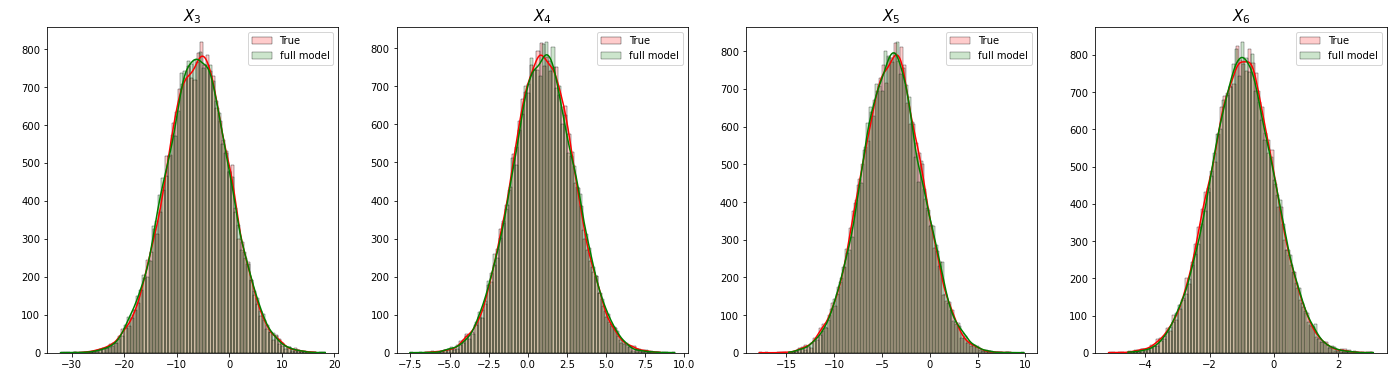

In [41]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(24, 6))


sample_X3={'True':Data['X3'].reshape(-1),'full':SCM_samples['X3'].detach().numpy().reshape(-1)}
sns.histplot(sample_X3['True'], ax=ax0, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(sample_Y['partial'], ax=ax1,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X3['full'], ax=ax0,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax0.legend()
ax0.set_ylabel(' ',fontweight='bold')
ax0.set_title(r'$X_{3}$',fontsize=15)



sample_X4={'True':Data['X4'].reshape(-1),'full':SCM_samples['X4'].detach().numpy().reshape(-1)}
sns.histplot(sample_X4['True'], ax=ax1, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(sample_Y['partial'], ax=ax1,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X4['full'], ax=ax1,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax1.legend()
ax1.set_ylabel(' ',fontweight='bold')
ax1.set_title(r'$X_{4}$',fontsize=15)

sample_X5={'True':Data['X5'].reshape(-1),'full':SCM_samples['X5'].detach().numpy().reshape(-1)}
sns.histplot(sample_X5['True'], ax=ax2, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(sample_X5['partial'], ax=ax2,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X5['full'], ax=ax2,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax2.legend()
ax2.set_ylabel(' ',fontweight='bold')
ax2.set_title(r'$X_{5}$',fontsize=15)


sample_X6={'True':Data['X6'].reshape(-1),'full':SCM_samples['X6'].detach().numpy().reshape(-1)}
sns.histplot(sample_X6['True'], ax=ax3, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(sample_X6['partial'], ax=ax3,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(sample_X6['full'], ax=ax3,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax3.legend()
ax3.set_ylabel(' ',fontweight='bold')
ax3.set_title(r'$X_{6}$',fontsize=15)


fig.savefig('additional_sampling_capabilities.pdf',format='pdf',dpi=600)

## Noise Inferrence Capabilities

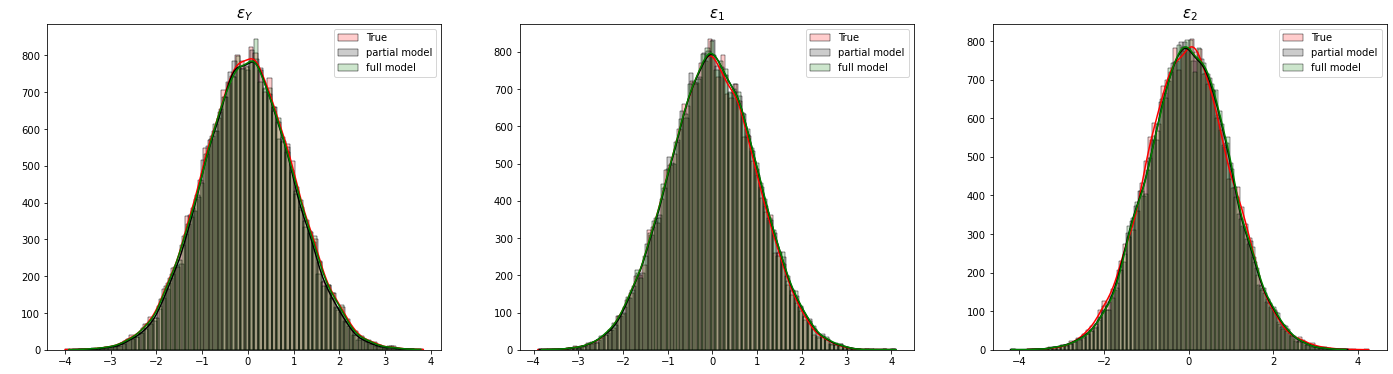

In [42]:
infer_noise_Y={'True':epsilon[:,0].reshape(-1),'partial':SCM_partial_inferred_noise['Y_base'].detach().numpy().reshape(-1),'full':SCM_inferred_noise['Y_base'].detach().numpy().reshape(-1)}
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 6))
sns.histplot(infer_noise_Y['True'], ax=ax1, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(infer_noise_Y['partial'], ax=ax1,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_Y['full'], ax=ax1,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax1.legend()
ax1.set_ylabel(' ',fontweight='bold')
ax1.set_title(r'$\epsilon_{Y}$',fontsize=15)

infer_noise_X1={'True':epsilon[:,1].reshape(-1),'partial':SCM_partial_inferred_noise['X1_base'].detach().numpy().reshape(-1),'full':SCM_inferred_noise['X1_base'].detach().numpy().reshape(-1)}
sns.histplot(infer_noise_X1['True'], ax=ax2, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(infer_noise_X1['partial'], ax=ax2,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X1['full'], ax=ax2,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax2.legend()
ax2.set_ylabel(' ',fontweight='bold')
ax2.set_title(r'$\epsilon_{1}$',fontsize=15)


infer_noise_X2={'True':epsilon[:,2].reshape(-1),'partial':SCM_partial_inferred_noise['X2_base'].detach().numpy().reshape(-1),'full':SCM_inferred_noise['X2_base'].detach().numpy().reshape(-1)}
sns.histplot(infer_noise_X2['True'], ax=ax3, color='red',legend=True,label='True',alpha=0.2,kde=True)
sns.histplot(infer_noise_X2['partial'], ax=ax3,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X2['full'], ax=ax3,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax3.legend()
ax3.set_ylabel(' ',fontweight='bold')
ax3.set_title(r'$\epsilon_{2}$',fontsize=15)


fig.savefig('inferred_noises.pdf',format='pdf',dpi=600)

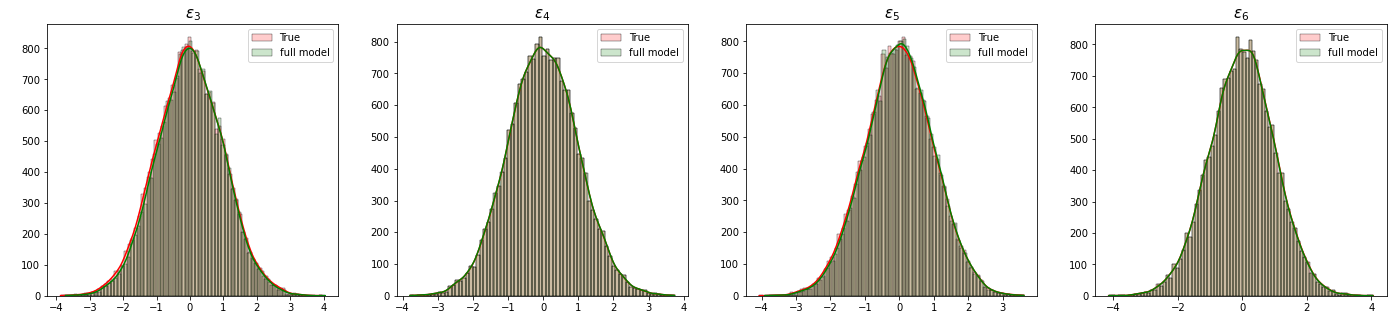

In [43]:
infer_noise_X3={'True':epsilon[:,3].reshape(-1),'full':SCM_inferred_noise['X3_base'].detach().numpy().reshape(-1)}
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(24, 5))
sns.histplot(infer_noise_X3['True'], ax=ax1, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(infer_noise_Y['partial'], ax=ax1,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X3['full'], ax=ax1,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax1.legend()
ax1.set_ylabel(' ',fontweight='bold')
ax1.set_title(r'$\epsilon_{3}$',fontsize=15)

infer_noise_X4={'True':epsilon[:,4].reshape(-1),'full':SCM_inferred_noise['X4_base'].detach().numpy().reshape(-1)}
sns.histplot(infer_noise_X4['True'], ax=ax2, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(infer_noise_X1['partial'], ax=ax2,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X4['full'], ax=ax2,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax2.legend()
ax2.set_ylabel(' ',fontweight='bold')
ax2.set_title(r'$\epsilon_{4}$',fontsize=15)


infer_noise_X5={'True':epsilon[:,5].reshape(-1),'full':SCM_inferred_noise['X5_base'].detach().numpy().reshape(-1)}
sns.histplot(infer_noise_X5['True'], ax=ax3, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(infer_noise_X2['partial'], ax=ax3,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X5['full'], ax=ax3,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax3.legend()
ax3.set_ylabel(' ',fontweight='bold')
ax3.set_title(r'$\epsilon_{5}$',fontsize=15)

infer_noise_X6={'True':epsilon[:,6].reshape(-1),'full':SCM_inferred_noise['X6_base'].detach().numpy().reshape(-1)}
sns.histplot(infer_noise_X6['True'], ax=ax4, color='red',legend=True,label='True',alpha=0.2,kde=True)
#sns.histplot(infer_noise_X2['partial'], ax=ax3,color='black',legend=True,label='partial model',alpha=0.2,kde=True)
sns.histplot(infer_noise_X6['full'], ax=ax4,color='green',legend=True,label='full model',alpha=0.2,kde=True)

ax4.legend()
ax4.set_ylabel(' ',fontweight='bold')
ax4.set_title(r'$\epsilon_{6}$',fontsize=15)


fig.savefig('additional_inferred_noises.pdf',format='pdf',dpi=900)

In [44]:
#sns.displot(SCM_inferred_noise['Y_base'].detach().numpy().reshape(-1),color='yellow',legend=True)
#sns.displot(SCM_partial_inferred_noise['Y_base'].detach().numpy().reshape(-1),color='black',legend=True)
#sns.displot(epsilon[:,0].reshape(-1),color='red',alpha=0.1,legend=True)
#plt.legend()

Counterfactuals

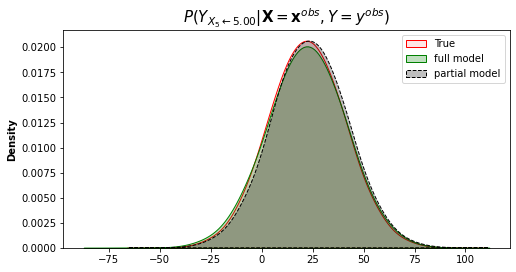

In [45]:
#sns.set_style('darkgrid')
data={'Y':Y_cf,'partial':SCM_partial_counterfactuals['Y'].detach().numpy().reshape(-1),'full':SCM_counterfactuals['Y'].detach().numpy().reshape(-1)}
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data['Y'], ax=ax, color='red', fill=True,bw_adjust=2,legend=True,label='True',alpha=0.1)
sns.kdeplot(data['full'], ax=ax, color='green',linestyle='-' ,fill=True,bw_adjust=2,legend=True,label='full model')
sns.kdeplot(data['partial'], ax=ax,color='black',linestyle='--' ,fill=True,bw_adjust=2,legend=True,label='partial model')
plt.legend()
plt.ylabel('Density',fontweight='bold')
plt.title(r'$P(Y_{X_{5}\leftarrow %.2f}|\mathbf{X}=\mathbf{x}^{obs},Y=y^{obs})$'%j,fontsize=15)
fig.savefig('toy_model2.pdf',format='pdf',dpi=600)


## Error Analysis

In [46]:
np.random.seed(seed)
intervention_set=np.random.uniform(-30,30,200)
error_full=[]
error_partial=[]

for j in intervention_set:
    intervention='do(X5='+str(j)+')'
    SCM_samples,SCM_inferred_noise,SCM_counterfactuals=do_inference(scm,intervention,noise=epsilon)
    SCM_partial_samples,SCM_partial_inferred_noise,SCM_partial_counterfactuals=do_inference(scm_partial,intervention,noise=epsilon)
    
    X6_cf, X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon,True,j)
    
    error_full.append( np.linalg.norm(Y_cf.reshape(-1)-SCM_counterfactuals['Y'].detach().numpy().reshape(-1))/(sample_size))
    error_partial.append(np.linalg.norm(Y_cf.reshape(-1)-SCM_partial_counterfactuals['Y'].detach().numpy().reshape(-1))/(sample_size))
        


 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=-17.27048428837601)

 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative power: {'X_6': tensor(0.), 'X_5': tensor(0.), 'X_4': tensor(0.), 'X_3': tensor(0.), 'X_2': tensor(-1.4160), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4415)}
intervention------ do(X5=-17.27048428837601)

 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=-14.458905568334313)

 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative powe

In [47]:
data=pd.DataFrame({'intervention':intervention_set,'error_partial':error_partial,'error_full': error_full})
data

,intervention,error_partial,error_full
0,-17.270484,0.010573,0.021480
1,-14.458906,0.009268,0.015645
2,-4.588687,0.002672,0.002662
3,13.179661,0.030020,0.107458
4,11.535056,0.026335,0.094149
...,...,...,...
195,29.711263,0.071403,0.161951
196,-3.429594,0.002289,0.002039
197,-3.816202,0.002416,0.002226
198,-4.362043,0.002614,0.002529


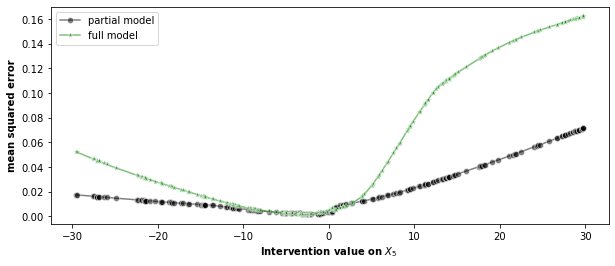

In [48]:

from matplotlib import pyplot as plt
#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 4))
#plt.scatter(intervention_set,np.exp(np.array(error_partial)),label='partial model',color='black',ls='-',marker='o')
#plt.scatter(intervention_set,np.exp(np.array(error_full)),label='full model',color='yellow',ls='--',marker='*')
sns.lineplot(data=data,x='intervention',y='error_partial',label='partial model',color='black',marker='o',alpha=0.5)
sns.lineplot(data=data,x='intervention',y='error_full',label='full model',color='green',marker='*',alpha=0.5)

plt.xlabel(r'Intervention value on $X_{5}$ ',fontweight='bold')
plt.ylabel('mean squared error',fontweight='bold')
plt.legend()
fig.savefig('error_synthetic_data.pdf',format='pdf',dpi=1200)

## Results on unseen data from the SCM
We don't train the SCM with these data points ....we just do inference

In [49]:
seed=89
np.random.seed(seed)
sample_size=20000
epsilon_unseen=np.random.normal(0,1,(sample_size,7))

In [50]:
X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(epsilon_unseen,False)
Data={'X6':torch.tensor(X_6).reshape(-1,1).float(),'X5':torch.tensor(X_5).reshape(-1,1).float(),'X4':torch.tensor(X_4).reshape(-1,1).float(),'X3':torch.tensor(X_3).reshape(-1,1).float(),'X2':torch.tensor(X_2).reshape(-1,1).float(),'X1':torch.tensor(X_1).reshape(-1,1).float(),'Y':torch.tensor(Y).reshape(-1,1).float()}

In [51]:
j= 1
intervention='do(X5='+str(j)+')'
X6_cf,X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon_unseen,True,j)      #True Counterfactuals
#np.mean(Y)

In [52]:
SCM_samples,SCM_inferred_noise,SCM_counterfactuals=do_inference(scm,intervention,noise=epsilon_unseen)
#np.mean(SCM_counterfactuals['Y'])


 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=1)


In [53]:
SCM_partial_samples,SCM_partial_inferred_noise,SCM_partial_counterfactuals=do_inference(scm_partial,intervention,noise=epsilon_unseen)
#np.mean(SCM_partial_counterfactuals['Y'])


 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative power: {'X_6': tensor(0.), 'X_5': tensor(0.), 'X_4': tensor(0.), 'X_3': tensor(0.), 'X_2': tensor(-1.4160), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4415)}
intervention------ do(X5=1)


/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

<AxesSubplot:ylabel='Density'>

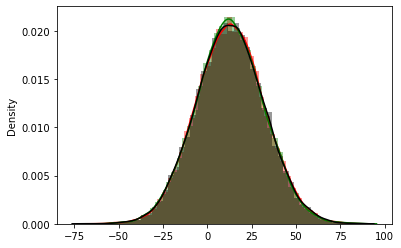

In [54]:
sns.distplot(Data['Y'].numpy(),kde=True,color='red')
sns.distplot(SCM_samples['Y'].numpy().reshape(-1),kde=True,color='green')
sns.distplot(SCM_partial_samples['Y'].numpy().reshape(-1),kde=True,color='black')

/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

<AxesSubplot:ylabel='Density'>

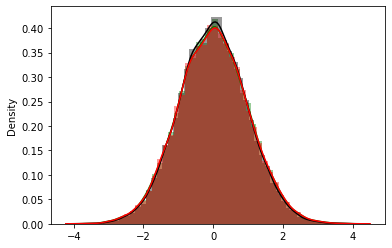

In [55]:
sns.distplot(SCM_inferred_noise['Y_base'].detach(),color='green')
sns.distplot(SCM_partial_inferred_noise['Y_base'].detach(),color='black')
sns.distplot(epsilon_unseen[:,0],color='red')

Text(0.5, 1.0, '$P(Y_{X_{5}\\leftarrow 1.00}|\\mathbf{X}=\\mathbf{x}^{obs},Y=y^{obs})$')

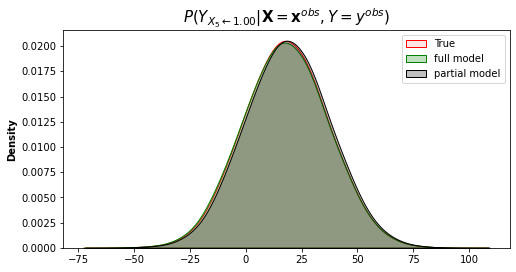

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set_style('darkgrid')

data={'Y':Y_cf,'partial':SCM_partial_counterfactuals['Y'].detach().numpy().reshape(-1),'full':SCM_counterfactuals['Y'].detach().numpy().reshape(-1)}
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data['Y'], ax=ax, color='red', fill=True,bw_adjust=2,legend=True,label='True',alpha=0.1)
sns.kdeplot(data['full'], ax=ax, color='green',linestyle='-' ,fill=True,bw_adjust=2,legend=True,label='full model')
sns.kdeplot(data['partial'], ax=ax,color='black',linestyle='-' ,fill=True,bw_adjust=2,legend=True,label='partial model')
plt.legend()
plt.ylabel('Density',fontweight='bold')
plt.title(r'$P(Y_{X_{5}\leftarrow %.2f}|\mathbf{X}=\mathbf{x}^{obs},Y=y^{obs})$'%j,fontsize=15)
#fig.savefig('toy_model_unseen_data.pdf',format='pdf',dpi=600)

In [57]:
intervention_set=np.random.uniform(-30,30,200)
error_full=[]
error_partial=[]

for j in intervention_set:
    intervention='do(X5='+str(j)+')'
    SCM_samples,SCM_inferred_noise,SCM_counterfactuals=do_inference(scm,intervention,noise=epsilon)
    SCM_partial_samples,SCM_partial_inferred_noise,SCM_partial_counterfactuals=do_inference(scm_partial,intervention,noise=epsilon)
    
    X6_cf, X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon,True,j)
    
    error_full.append( np.linalg.norm(Y_cf.reshape(-1)-SCM_counterfactuals['Y'].detach().numpy().reshape(-1))/(sample_size))
    error_partial.append(np.linalg.norm(Y_cf.reshape(-1)-SCM_partial_counterfactuals['Y'].detach().numpy().reshape(-1))/(sample_size))
    
    


 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=-2.578785218505285)

 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative power: {'X_6': tensor(0.), 'X_5': tensor(0.), 'X_4': tensor(0.), 'X_3': tensor(0.), 'X_2': tensor(-1.4160), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4415)}
intervention------ do(X5=-2.578785218505285)

 logs/ConditionalSCM/flow_best.pth.tar
====>>> Best LogProb: -11.735043

associative power: {'X_6': tensor(-1.4198), 'X_5': tensor(-1.4166), 'X_4': tensor(-2.1126), 'X_3': tensor(-1.4229), 'X_2': tensor(-1.4163), 'X_1': tensor(-2.5050), 'Y': tensor(-1.4418)}
intervention------ do(X5=5.820143962001708)

 logs/ConditionalSCM_partial/flow_best.pth.tar
====>>> Best LogProb: -5.362494

associative power:

In [58]:
data=pd.DataFrame({'intervention':intervention_set,'error_partial':error_partial,'error_full': error_full})
data

,intervention,error_partial,error_full
0,-2.578785,0.186475,0.186623
1,5.820144,0.186705,0.192232
2,16.289791,0.188209,0.231960
3,-18.522296,0.187517,0.189652
4,29.581046,0.198301,0.258711
...,...,...,...
195,-17.540823,0.187425,0.189228
196,10.501694,0.186919,0.210126
197,-12.333331,0.186973,0.187515
198,10.094646,0.186894,0.208185


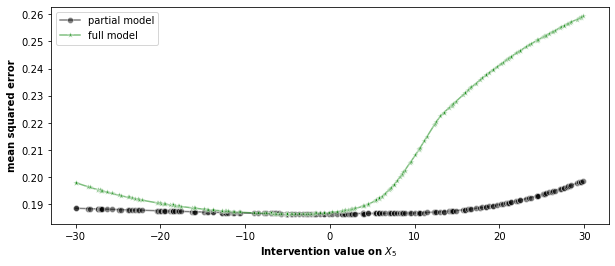

In [59]:

from matplotlib import pyplot as plt
#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 4))
#plt.scatter(intervention_set,np.exp(np.array(error_partial)),label='partial model',color='black',ls='-',marker='o')
#plt.scatter(intervention_set,np.exp(np.array(error_full)),label='full model',color='yellow',ls='--',marker='*')
sns.lineplot(data=data,x='intervention',y='error_partial',label='partial model',color='black',marker='o',alpha=0.5)
sns.lineplot(data=data,x='intervention',y='error_full',label='full model',color='green',marker='*',alpha=0.5)

plt.xlabel(r'Intervention value on $X_{5}$ ',fontweight='bold')
plt.ylabel('mean squared error',fontweight='bold')
plt.legend()
fig.savefig('testerror_synthetic_data.pdf',format='pdf',dpi=1200)